# DataRobot API Workflow
This code example outlines how to use the Python client to train models and experiment. It also offers ideas for integrating DataRobot with other products via API.  

Specifically, you will:

Create a project and run AutoPilot via the API  
Experiment with feature lists, modeling algorithms, and hyperparameters  
Choose the best model  
Perform in-depth evaluation of the selected model  
Deploy a model into production in a few lines of code  

# Background
This walkthrough uses a synthetic dataset that illustrates a credit card company’s AML compliance program, with the intent of detecting the following money-laundering scenarios:

- A customer spends on the card, but overpays their credit card bill and seeks a cash refund for the difference.
- A customer receives credits from a merchant without offsetting transactions, and either spends the money or requests a cash refund from the bank.

A rule-based engine is in place to produce an alert when it detects potentially suspicious activity consistent with the scenarios above. The engine triggers an alert whenever a customer requests a refund of any amount. Small refund requests are included because they could be a money launderer’s way of testing the refund mechanism or trying to establish refund requests as a normal pattern for their account.

The target feature is SAR. It indicates whether or not the alert resulted in an Suspicious Activity Report (SAR) after manual review by investigators, which means that this project is framed as a binary classification problem. The unit of analysis is an individual alert, so the model will be built on the alert level. Each alert will get a score ranging from 0 to 1, indicating the probability of being an alert leading to an SAR. The data consists of a mixture of numeric, categorical and text data.

In [10]:
import os 
import time 
import warnings 

import datarobot as dr
import matplotlib.pyplot as plt
import pandas as pd
import requests 
import seaborn as sns
%matplotlib inline 

warnings.filterwarnings("ignore")

# wider .head()s
pd.options.display.width = 0
pd.options.display.max_columns = 200
pd.options.display.max_rows = 2000
#sns.set_theme(style="darkgrid")

RANDOM_SEED = 321

In [4]:
df = pd.read_csv('https://s3.amazonaws.com/datarobot_public_datasets/DR_Demo_AML_Alert.csv')

In [5]:
df.head()

,ALERT,SAR,kycRiskScore,income,tenureMonths,creditScore,state,nbrPurchases90d,avgTxnSize90d,totalSpend90d,csrNotes,nbrDistinctMerch90d,nbrMerchCredits90d,nbrMerchCreditsRndDollarAmt90d,totalMerchCred90d,nbrMerchCreditsWoOffsettingPurch,nbrPayments90d,totalPaymentAmt90d,overpaymentAmt90d,overpaymentInd90d,nbrCustReqRefunds90d,indCustReqRefund90d,totalRefundsToCust90d,nbrPaymentsCashLike90d,maxRevolveLine,indOwnsHome,nbrInquiries1y,nbrCollections3y,nbrWebLogins90d,nbrPointRed90d,PEP
0,1,0,3,110300.0,5,757,PA,10,153.80,1538.00,,7,2,0,308.98,0,5,76.90,0.00,0,1,1,45.82,5,6000,0,3,0,6,1,0
1,1,0,2,107800.0,6,715,NY,22,1.59,34.98,card replace billing address billing address,11,2,0,3.28,1,4,60.00,25.02,1,2,1,67.40,0,10000,1,3,0,87,0,0
2,1,0,1,74000.0,13,751,MA,7,57.64,403.48,billing address customer call,4,0,0,0.00,0,4,796.63,393.15,1,2,1,450.69,0,10000,0,3,0,6,0,0
3,1,0,0,57700.0,1,659,NJ,14,29.52,413.28,,7,2,0,59.14,1,3,413.28,0.00,0,1,1,71.43,0,8000,1,5,0,7,2,0
4,1,0,1,59800.0,3,709,PA,54,115.77,6251.58,change request statement late payment bitcoin,16,7,2,785.85,2,3,8928.41,2676.83,1,2,1,2731.39,3,7000,1,1,0,8,1,0


In [6]:
df['SAR'].value_counts()

0    8974
1    1026
Name: SAR, dtype: int64

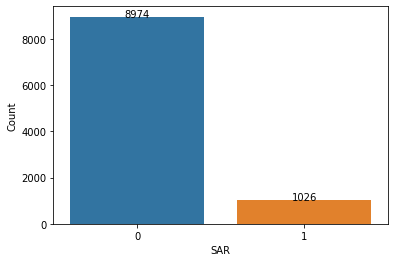

In [11]:
# To view target distribution:
df_target_summary = (
    pd.DataFrame(df["SAR"].value_counts())
    .reset_index()
    .rename(columns={"index": "SAR", "SAR": "Count"})
)
ax = sns.barplot(x="SAR", y="Count", data=df_target_summary)

for index, row in df_target_summary.iterrows():
    ax.text(row.SAR, row.Count, round(row.Count, 2), color="black", ha="center")

plt.show()

In [12]:
df_target_summary

,SAR,Count
0,0,8974
1,1,1026


In [15]:
dr.Client(config_path = "./drconfig.yaml")

# Create a DR project and train models with Autopilot

In [16]:
project = dr.Project.create(
                    sourcedata= df,
                    project_name= 'DR_Demo_API_AML_CodeCentric_{}'.format(pd.datetime.now().strftime("%Y-%m-%d %H:%M")))


In [17]:
project.set_target(
    target="SAR",
    mode="quick",
    worker_count=-1,
    advanced_options=dr.AdvancedOptions(seed=RANDOM_SEED),
)

Project(DR_Demo_API_AML_CodeCentric_2022-06-26 19:06)

In [18]:
project.open_leaderboard_browser()

True

In [19]:
project.wait_for_autopilot(verbosity=1)

In progress: 1, queued: 0 (waited: 0s)
In progress: 1, queued: 0 (waited: 1s)
In progress: 1, queued: 0 (waited: 2s)
In progress: 1, queued: 0 (waited: 4s)
In progress: 1, queued: 0 (waited: 5s)
In progress: 1, queued: 0 (waited: 8s)
In progress: 1, queued: 0 (waited: 12s)
In progress: 0, queued: 0 (waited: 19s)
In progress: 5, queued: 0 (waited: 33s)
In progress: 5, queued: 0 (waited: 54s)
In progress: 3, queued: 0 (waited: 75s)
In progress: 1, queued: 0 (waited: 96s)
In progress: 16, queued: 0 (waited: 117s)
In progress: 10, queued: 0 (waited: 138s)
In progress: 4, queued: 0 (waited: 159s)
In progress: 0, queued: 0 (waited: 180s)
In progress: 0, queued: 0 (waited: 201s)
In progress: 0, queued: 0 (waited: 222s)
In progress: 5, queued: 0 (waited: 244s)
In progress: 5, queued: 0 (waited: 264s)
In progress: 1, queued: 0 (waited: 286s)
In progress: 0, queued: 0 (waited: 306s)
In progress: 1, queued: 1 (waited: 328s)
In progress: 1, queued: 1 (waited: 349s)
In progress: 1, queued: 0 (waite

In [24]:
from datarobot_bp_workshop import Visualize
from src.helper import (
    draw_feature_histogram,
    get_top_of_leaderboard,
)

ModuleNotFoundError: No module named 'datarobot_bp_workshop'

In [22]:
# To access an existing project set your project ID below
project = dr.Project.get("62b6c8649e36e6466dd92484")

print("Project URL: " + "https://app.datarobot.com/projects/" + project.id + "/eda")
print("Project ID: " + project.id)

leaderboard_top = get_top_of_leaderboard(project, metric="AUC")

Project URL: https://app.datarobot.com/projects/62b6c8649e36e6466dd92484/eda
Project ID: 62b6c8649e36e6466dd92484


NameError: name 'get_top_of_leaderboard' is not defined

In [1]:
from datarobot_bp_workshop import Visualize

ModuleNotFoundError: No module named 'datarobot_bp_workshop'